

## Variance stablizing transform##

To have an unbiased estimate of fraction of variance explained we will stabilize the variance to simplify calculations.

I will assume that the variance to mean relationship is:

$$\sigma^2(\mu) = a\mu^b$$

Thus to stabilize the variance approximately to 1 we apply this transformation to our data:

$$f(x) = (\sqrt{a}(1-\frac{1}{2}b))^{-1}x^{1-\frac{1}{2}b}$$

We do not know $a$ and $b$ a priori so we must estimate it from the data:
$$\sigma^2(\mu) = a\mu^b$$
$$\log(\sigma^2(\mu)) = \log(a\mu^b)$$
$$\log(\sigma^2(\mu)) = \log(a) + b\log(\mu)$$

so will use a linear model:

$$\log(s^2) = \log(a) + b\log(\bar{x}) + \epsilon$$


Assuming the transformation is well estimated, our sample mean neural response distribution has become a spherical guassian with a known variance $1$ but unknown mean $f({\lambda_i})$.  Our model $x_i$,  becomes, $f(x_i)$ but for simplicity lets call it $\vec{x}$ mean centered and normalized unit length and call $Y_i$ as $\vec{Y}$.

So now with the square root transformation what is the distribution of $R^2 = Cor(\vec{Y}, \vec{x})^2$?

Set up:

We have $m$ stimuli and $n$ trials:

$\vec{Y} \sim \frac{1}{n} \sum^n{N(\lambda, a\lambda^b)}$

We transform each set of trials so we have
$$\vec{Y} \sim N(f(\lambda), \frac{1}{n}) \sim \frac{1}{n} \sum^n{N(f(\lambda), 1)}$$

Now lets make sure the transform works:

[]

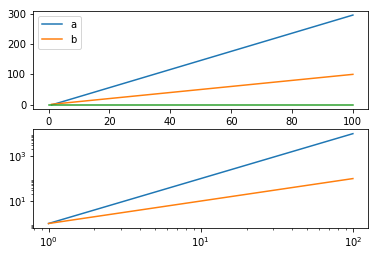

In [466]:
#first lets make a flexible mean variance function, we will use Poisson whose rate is conditioned
#on a uniform.
import matplotlib.pyplot as plt
%matplotlib inline
u = np.linspace(1,100,100)
s2 = 1*u**2


a = u + np.sqrt(4*s2-4*u+1) - 3
b = u
plt.subplot(211)
plt.plot(u,a)
plt.plot(u,b)
plt.plot([0,100], [0,0])
plt.legend(['a','b'])
plt.subplot(212)
plt.plot(u,s2)
plt.plot([1,100], [1,100])

plt.loglog()

In [467]:
u  = 10
s2 = u**2

a = u + np.sqrt(4*s2-4*u+1) - 3
b = u

ber = np.random.binomial(1, 0.5, 100)* + (a+b)/2
print(ber)

[ 0. 18.  0.  0. 18.  0. 18.  0.  0. 18. 18. 18. 18. 18.  0. 18. 18.  0.
  0.  0. 18.  0. 18. 18. 18. 18. 18. 18. 18.  0. 18. 18.  0.  0.  0. 18.
 18.  0.  0.  0.  0.  0. 18.  0. 18.  0.  0.  0.  0.  0. 18. 18.  0.  0.
  0.  0. 18.  0.  0. 18. 18. 18. 18. 18.  0. 18.  0.  0. 18. 18. 18.  0.
 18. 18. 18. 18. 18. 18. 18.  0.  0. 18. 18.  0.  0.  0. 18. 18. 18.  0.
 18.  0. 18. 18. 18. 18.  0. 18.  0.  0.]


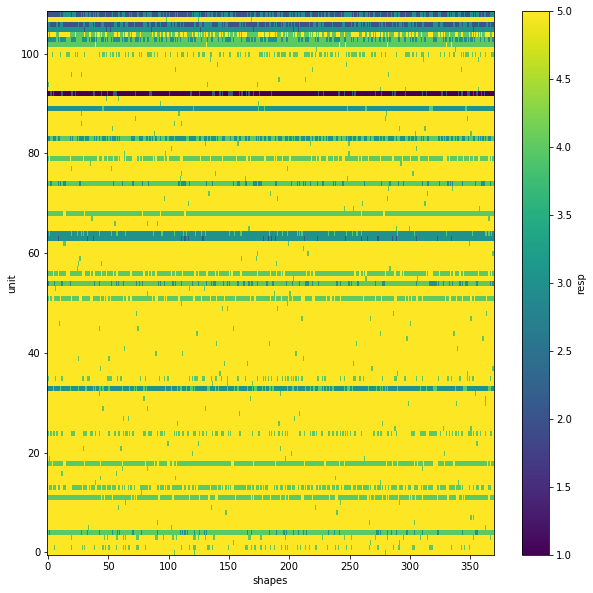

In [468]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import seaborn

plt.figure(figsize=(10,10))
top_dir = '/Users/deanpospisil/Desktop/modules/v4cnn/'
v4_name = 'apc370_with_trials'

v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/apc_orig/' + v4_name + '.nc')['resp'].load()
units = np.sqrt(v4_resp_apc)

dmod = xr.open_dataset('/Users/deanpospisil/Desktop/modules/v4cnn/data/models/' + 'apc_models_362.nc')['resp'].load()
v4_resp_apc = v4_resp_apc[:,1:]
v4_resp_apc = np.sqrt(v4_resp_apc[:,dmod.coords['shapes'].values])
v4_n = v4_resp_apc.mean('trials')-v4_resp_apc.mean(['shapes', 'trials'])
v4_n = v4_n/ v4_n.dot(v4_n, 'shapes')**0.5

(~v4_resp_apc.isnull()).sum('trials').plot()

(109, 371, 25)


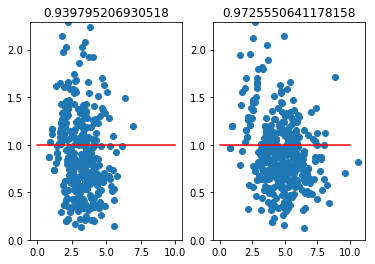

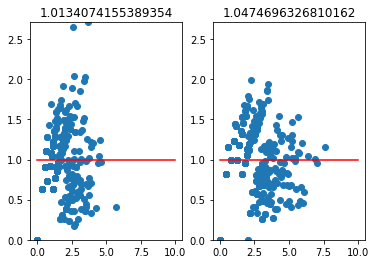

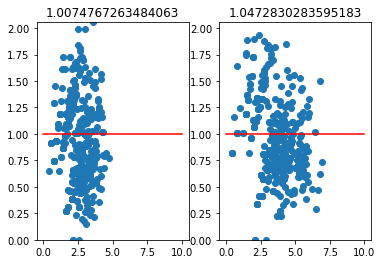

In [489]:
v4_resp_apc = xr.open_dataset(top_dir + 'data/responses/apc_orig/' + v4_name + '.nc')['resp'].load()
from scipy import stats
import numpy as np
print(v4_resp_apc.shape)

def transform(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y
def vmr(y):
    y_var = np.var(y,0,ddof=1)
    y_bar = np.mean(y,0)
    
    ind = (y_bar>0)*(y_var>0)
    
    rat = ((y_var[ind])/(y_bar[ind])).mean()
    return rat

for u in v4_resp_apc[[35,49, 23]]:
    y = u.dropna('trials', how='any').dropna('shapes', how='any').values.T
    a = vmr(y)
    yt = transform(y, a=a, b=1)
    plt.figure()
    plt.subplot(121)
    y_bar = np.mean(yt,0)
    y_var = np.std(yt,0)
    top = y_var.max()
    plt.scatter(y_bar,y_var)
    plt.title(yt.var(0).mean())

    plt.plot([0,10],[1,1], c='r')
    plt.ylim(0,top)

    plt.subplot(122)
    y = np.random.poisson(np.mean(y,0), size=(n, y.shape[1])) # n_experiments n_trials m_stimuli
    a = vmr(y)
    yt = transform(y, a=a, b=1)
    y_bar = np.mean(yt,0)
    y_var = np.std(yt,0)
    plt.scatter(y_bar, y_var)
    plt.ylim(0,top)
    plt.plot([0,10],[1,1], c='r')
    plt.title(yt.var(0).mean())
    #plt.plot([1,100],[1,100])
    #plt.ylim(1,100);plt.xlim(1,100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def transform(x, a, b):
    y = (2*x)*((b-2.)*np.sqrt(a*x**b))**-1
    if b == 2:
        y = np.log(x)
    return y

n = 5 #trials
m = 100 #stimuli
n_exps = 5000 #number simulations
lambdas = np.linspace(10, 1000, m)

a = 3.
b = 1
ns = np.linspace(10,1000, m)
ps = np.linspace(0.1,.9, m)



print(ps.shape)
print(ns.shape)

y = np.random.normal(lambdas, (a*lambdas**b)**0.5, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.random.negative_binomial(ns, ps, size=(n_exps, n, m))
y[y<=0] = 0.01

y = transform(y, a, b)

y_bar = y.mean(1) # average the trials
y_var = y.var(1, ddof=1)

plt.scatter(lambdas, y_var.mean(0));


print(y_bar.shape)

In [227]:
import numpy as np

#fit vmr
intercept = np.ones(m)
vmr_fit = []
for i in range(n_exps):
    mt = np.log(y_bar[i])
    vt = np.log10(y_var[i])
    A = np.vstack([mt, intercept]).T
    b_est, c = np.linalg.lstsq(A, vt)[0]
    a_est = 10.**c 
    vmr_fit.append([a_est, b_est])
vmr_fit = np.array(vmr_fit)  
    

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


## The distribution of $R^2$  ##

$R^2$ is just $\frac{Explained \ variance}{Total  \ variance} $ lets examine the numerator and denominator seperately.

### Explained  variance ###

Well the model of our responses is:
$$ \vec{Y} = \mu + \beta \vec{x} + \alpha \vec{e} + \vec{\epsilon} $$

$$\epsilon_i \sim N(0,\frac{1}{n})$$
$\alpha \vec{e}$ is the residual of our true means and model.

Explained variance is just the squared length of our fit of $\vec{x}$ to $\vec{Y}$ : $|\hat{\beta}\vec{x}|^2$

where $\hat{\beta}$ is the signed length of the projection of $\vec{x}$ on $\vec{Y}$ which has a normal distribution (it is just a linear transformation of a normal so is normal):
$$\hat{\beta} = \frac{\vec{Y} \cdot \vec{x}}{|\vec{x}|^2} = \vec{Y} \cdot \vec{x} \sim N(\beta, \frac{1}{n})$$
so the squared length is then a scaled non-central chi-squared random variable with m degrees of freedom because it is a sum of m squared normals:
$$|\hat{\beta}\vec{x}|^2 \sim \frac{1}{n} \chi^2_m(n\beta^2) $$ keeping in mind that $\beta^2 = \sum_i^m{(f({\lambda_i}) - \overline{{f({\lambda}})})^2}$. 

### Total variance ###

$\chi^2_1(n\beta^2) +  \chi^2_{m-2}(n\alpha^2)$

### Putting this all together ###

$$ R^2 \sim \frac{\frac{1}{n} \chi^2_1(n\beta^2)}{\frac{1}{n} \chi^2_1(n\beta^2) +  \frac{1}{n} \chi^2_{m-2}(n\alpha^2)} = \frac{ \chi^2_1(n\beta^2)}{ \chi^2_1(n\beta^2) +  \chi^2_{m-2}(n\alpha^2)} $$

Since for a non-central chi-squared random variable: $E[\chi^2_m(a)] = a + m$

$$Numerator \ \ E[\frac{1}{n} \chi^2_1(n\beta^2)] = \frac{1}{n} E[\chi^2_1(n\beta^2)] = \frac{1}{n}(1 + n\beta^2) = \beta^2 + \frac{1}{n} $$

$$Denominator \ \ E[\frac{1}{n} \chi^2_{m-2}(n\alpha^2) + \frac{1}{n} \chi^2_{1}(n\beta^2)] = \alpha^2 + \frac{1}{n}(m-2) + \beta^2 + \frac{1}{n}$$


while this is a bit of a hack we will just subtract of the right amount from the numerator and denominator to make them approximately unbiased:

Numerator correction $= - \frac{1}{n}$

Denominator correction $=- \frac{1}{n}(m-2) - \frac{1}{n}$

So lets give it a try:

In [490]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.nonparametric.kernel_regression as kr

def transform(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y

def r2_unbiased(y, x):
    (n, m) = np.shape(y)
    y = y.mean(0)
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

def kernel_reg_v_pred(y):
    y_bar = y.mean(0)
    y_var = y.var(0)
    
    v_pred = kr.KernelReg((y_var), (y_bar), 'c', reg_type='lc', bw='aic').fit(y_bar)[0];
    return v_pred
      
def log_lin_vpred(y):
    y_bar = y.mean(0)
    y_var = y.var(0)
    
    ml = np.log10(y_bar)
    vl = np.log10(y_var)
    intercept= np.ones(len(ml))
    A = np.vstack([ml, intercept]).T
    b_est, c = np.linalg.lstsq(A, vl)[0]
    b = b_est
    a = 10.**c
    
    return (a,b)

def r2_unbiased_vmr(y, x, ab):
    (a,b) = ab
    (n, m) = np.shape(y)
    y = transform(y, a, b)
    y = y.mean(0)
    
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))
    R2_corrected = (num - (1./n))/((den - (m-1)*(1./n)))
    return R2_corrected, R2

n = 5 #trials
m = 362 #stimuli
n_exps = 100 #number simulations
amplitude = 5.
base_line = 10
true_r2 = 0.5
angle = np.arccos(true_r2**0.5)

a = 1
b = 1

#create the expected responses
lambdas = base_line + (np.cos(np.linspace(0, 2*np.pi, m))*amplitude) #s
#our model is not perfect, thus its angle is some angle off
model = base_line+(np.cos(angle + np.linspace(0, 2*np.pi, m))*amplitude) #s
a=1
b=1

y = np.random.normal(lambdas, a*lambdas**b, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.random.poisson(lambdas, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.random.negative_binomial(lambdas, 0.1, size=(n_exps, n, m))
y_bar = y.mean(1)
y_var = np.var(y, 1)
inds = (y_var>0)*(y_bar>0)
print(np.shape(inds))
#r2_vmr = np.array([r2_unbiased_vmr(exp, model, n, m) for exp in y])
r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], log_lin_vpred(exp[:,ind])) for exp, ind in zip(y, inds)])
r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], (vmr(exp[:,ind]),1)) for exp, ind in zip(y, inds)])

#r2_logfit = np.array([r2_unbiased_vmr(exp[:,ind], model[ind], exp[:,ind].mean(0)) for exp, ind in zip(y, inds)])

y = 2*np.sqrt(y)
r2_per_trans= np.array([r2_unbiased(exp[:,ind], model[ind]) for exp, ind in zip(y, inds)])

(100, 362)


/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


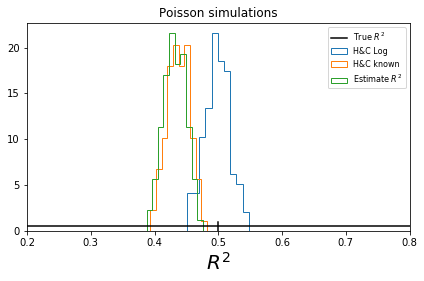

In [493]:
#import seaborn as sns
#sns.reset_defaults()
plt.hist(r2_logfit[..., 0], normed=True,  histtype='step', bins=10)
#plt.hist(r2_vmr[..., 0], normed=True,  bins=10, histtype='step',cumulative=True)
plt.hist(r2_per_trans[..., 0], normed=True,  bins=10, histtype='step')
plt.hist(r2_per_trans[..., 1], normed=True,  bins=10, histtype='step')


actual_r = np.corrcoef(np.sqrt(model), np.sqrt(lambdas))[0,1]**2
plt.plot([true_r2, true_r2], [0,1], c='k')
plt.xlim([0.2, .8])
plt.legend([ r'True $R^2$', r'H&C Log', r'H&C known', r'Estimate $R^2$', ], loc='upper right', fontsize=8)
plt.xlabel(r'$R^2$', fontsize=20)
plt.title('Poisson simulations')
plt.plot([0, 1], [.5,.5], c='k')

plt.tight_layout()

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10


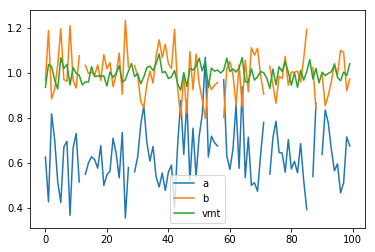

In [438]:
y = np.random.poisson(lambdas, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli

def vmr(y):
    y_var = np.var(y,0,ddof=1)
    y_bar = np.mean(y,0)
    rat = ((y_var)/(y_bar)).mean()
    return rat

plt.plot([log_lin_vpred(exp[:,ind]) for exp, ind in zip(y, inds)])
plt.plot([vmr(exp) for exp, ind in zip(y, inds)])
plt.legend(['a','b','vmt'])

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[1.         0.94918032]
 [0.94918032 1.        ]]


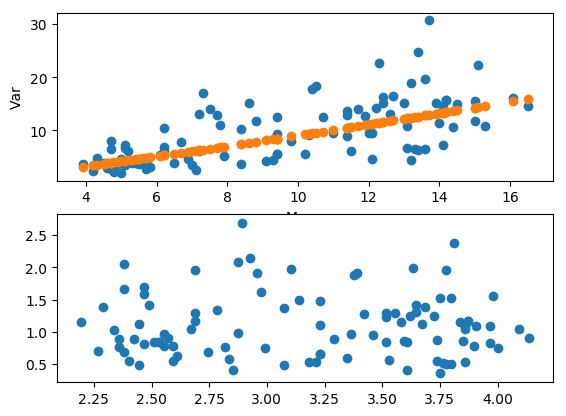

In [353]:
n = 10 #trials
m = 100 #stimuli
n_exps = 1000 #number simulations
lambdas = lambdas.astype(int)
p=1./lambdas

true_mu = (lambdas*(1-p))/(p)
true_var = ((1-p)*lambdas)/(p**2)

y = np.random.negative_binomial(lambdas, p, size=(n_exps, n, m))[0]
y = np.random.poisson(lambdas, size=(n_exps, n, m))[0]

y_bar = y.mean(0)
y_var = np.var(y, 0, ddof=1)

ind = np.array((y_bar>0)*(y_var>0)).squeeze()
y = y[...,ind]

y_var = y_var[ind]
y_bar = y_bar[ind]


#v_pred = st.nonparametric.kernel_regression.KernelReg((y_var), 
#                                                      (y_bar), 
#                                                      'c', 
#                                                      reg_type='lc').fit(y_bar);


v_pred = v_pred[0]

ml = np.log10(y_bar)
vl = np.log10(y_var)
intercept= np.ones(len(ml))
A = np.vstack([ml, intercept]).T
b_est, c = np.linalg.lstsq(A, vl)[0]
b = b_est
a = 10.**c

v_pred = a*y_bar**b

y_new = y/(v_pred**0.5)

plt.subplot(211)
plt.scatter(y_bar, y_var)
plt.scatter(y_bar, v_pred)
plt.xlabel('Mean')
plt.ylabel('Var')
#plt.loglog()

#plt.scatter(true_mu, true_var, color='r')

plt.subplot(212)

y_bar = y_new.mean(0)
y_var = np.var(y_new, 0,ddof=1)
plt.scatter(y_bar, y_var)

#plt.loglog()

print(np.corrcoef(true_mu, y_bar))

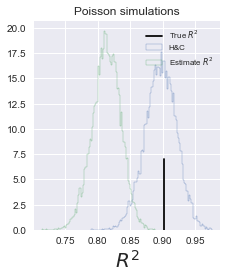

In [104]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def r2_unbiased(y, x, n, m):
    y -= y.mean()
    x -= x.mean()
    b = np.dot(y, x)/np.dot(x, x)
    y_hat = b*x#our best fit of x to y in the 1-d model space
    res = y-b*x#the left over residual in (m-2)-d null space
    num = np.sum(y_hat**2)
    den = np.sum(y_hat**2) + np.sum(res**2)
    
    R2 = (num)/(den)    
    R2_corrected = (num - (1./n))/((den - (m-2)*(1./n) - (1./n)))

    return R2_corrected, R2

n = 4 #trials
m = 40 #stimuli
n_exps = 5000 #number simulations
amplitude = 3
base_line = 4
true_r2 = 0.5
angle = np.arccos(true_r2**0.5)

a = 1
b = 1

#create the expected responses
lambdas = base_line + (np.cos(np.linspace(0, 2*np.pi, m))*amplitude) #s
#our model is not perfect, thus its angle is some angle off
model = base_line+(np.cos(angle + np.linspace(0, 2*np.pi, m))*amplitude) #s

y = np.random.normal(lambdas, (a*lambdas**b)**0.5, size=(n_exps, n, m)) # n_experiments n_trials m_stimuli
y = np.abs(y)
y_bar = y.mean(1,) # average the trials
y_var = y.var(1, ddof=1,)

#fit vmr
intercept = np.ones(m)
'''
print(intercept.shape)
print(y_bar.shape)
vmr_fit = []
for i in range(n_exps):
    mt = np.log(y_bar[i])
    vt = np.log10(y_var[i])
    A = np.vstack([mt, intercept]).T
    b_est, c = np.linalg.lstsq(A, vt)[0]
    a_est = 10.**c 
    vmr_fit.append([a_est, b_est])
vmr_fit = np.array(vmr_fit)  
    
'''
def transform(x, a, b):
    y = ((np.sqrt(a)*(1-0.5*b))**-1)*x**((1-0.5*b))
    return y

#get the fraction of variance
#r2 = np.array([r2_unbiased(transform(exp, the_a, the_b), transform(model, the_a, the_b), n, m) 
#               for exp, the_a, the_b in zip(y_bar.squeeze(), vmr_fit[:,0], vmr_fit[:,1])])

#r2 = np.array([r2_unbiased(transform(exp, 1, 1), transform(model, 1, 1), n, m) 
#               for exp, the_a, the_b in zip(y_bar.squeeze(), vmr_fit[:,0], vmr_fit[:,1])])



r2 = np.array([r2_unbiased(np.sqrt(exp), np.sqrt(model), n, m) for exp in y_bar])

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


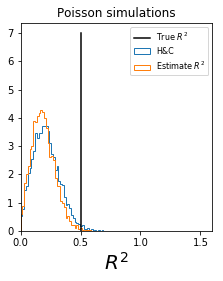

In [107]:
plt.subplot(122)
#plt.plot(np.sqrt(model))
#plt.plot(np.sqrt(lambdas))
#plt.xlabel('Stimuli');plt.ylabel('sqrt(spk/s)')
#plt.tight_layout()

plt.hist(r2[..., 0], normed=True, range=(0,1.5), histtype='step', bins=100)
plt.hist(r2[..., 1], normed=True, range=(0,1.5), bins=100, histtype='step',)


actual_r = np.corrcoef(np.sqrt(model), np.sqrt(lambdas))[0,1]**2
plt.plot([actual_r, actual_r], [0,7], c='k')
plt.xlim([0, 1.6])
plt.legend([ r'True $R^2$', r'H&C', r'Estimate $R^2$', ], loc='upper right', fontsize=8)
plt.xlabel(r'$R^2$', fontsize=20)
plt.title('Poisson simulations')
plt.tight_layout()